In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import os

import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
# Controlla le GPU disponibili
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Numero di GPU disponibili: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome GPU: {gpu.name}")
else:
    print("Nessuna GPU disponibile")

Numero di GPU disponibili: 1
Nome GPU: /physical_device:GPU:0


In [3]:
x = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_images.npy")
y = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_labels.npy")

#creazione dei vari dataset
seed = 1999
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

#creazione validation set e train set
x_valid_images = train_images[1000:]/255.
x_valid_labels = train_labels[1000:]
x_train_images = train_images[:1000]/255.
x_train_labels = train_labels[:1000]

#normalizzazione anche del test set
test_images = test_images/255.

5232 5232


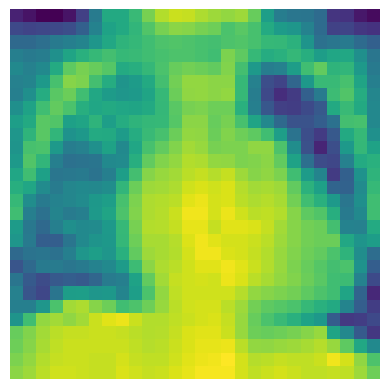

[1]


In [4]:
print(len(x), len(y))
plt.imshow(x_train_images[0])
plt.axis('off')
plt.show()
print(y[0])

## CNN con blocco Inception

L'idea è quella di costruire una CNN che richiami quella sviluppata da Google (GoogLeNet) andando a sfruttare il blocco transformer. Si opera questa scelta perché una rete del genere ha mostrato ottime prestazioni in passato, e per non dover cercare di ottimizzare il tipo di Pooling e la dimensione dei Kernel, andandone a sfruttare di diverse dimensioni all'interno del blocco Inception.

In [5]:
# Funzione per creare un blocco Inception
def inception_module(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # Primo blocco Inception
    x = inception_module(inputs, 32)
    
    # Secondo blocco Inception
    x = inception_module(x, 64)
    
    # Terzo blocco Inception
    x = inception_module(x, 128)
    
    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    
    # Aggiunta di un livello denso per la classificazione
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1) per immagini in scala di grigi
input_shape = (28, 28, 1)
model = create_inception_cnn(input_shape)

# Compilazione del modello
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
#model.summary()

Epoch 1/100
32/32 [==============================] - 10s 90ms/step - loss: 0.6448 - accuracy: 0.7030 - val_loss: 0.5636 - val_accuracy: 0.7449
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 0.5831 - accuracy: 0.7290 - val_loss: 0.5638 - val_accuracy: 0.7449
Epoch 3/100
32/32 [==============================] - 2s 60ms/step - loss: 0.5734 - accuracy: 0.7290 - val_loss: 0.5511 - val_accuracy: 0.7449
Epoch 4/100
32/32 [==============================] - 2s 57ms/step - loss: 0.5520 - accuracy: 0.7300 - val_loss: 0.5820 - val_accuracy: 0.7449
Epoch 5/100
32/32 [==============================] - 2s 57ms/step - loss: 0.6117 - accuracy: 0.6820 - val_loss: 0.5357 - val_accuracy: 0.7449
Epoch 6/100
32/32 [==============================] - 2s 60ms/step - loss: 0.5354 - accuracy: 0.7430 - val_loss: 0.5236 - val_accuracy: 0.7495
Epoch 7/100
32/32 [==============================] - 2s 60ms/step - loss: 0.4987 - accuracy: 0.7680 - val_loss: 0.4013 - val_accuracy: 0.8177
Epoch

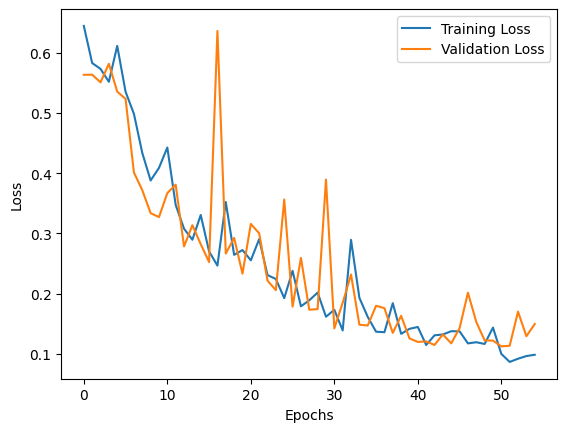

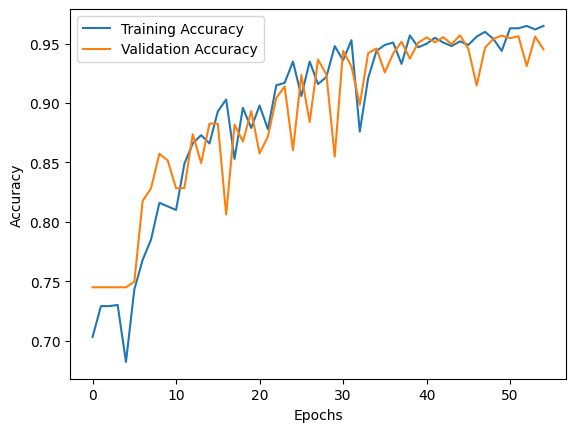

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Addestramento del modello
history = model.fit(x_train_images, x_train_labels, epochs=100,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])

# Dopo l'addestramento, puoi visualizzare la storia dell'addestramento
import matplotlib.pyplot as plt

# Plot della perdita di addestramento e validazione
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot dell'accuratezza di addestramento e validazione
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
model.evaluate(test_images, test_labels)

17/17 [==============================] - 0s 19ms/step - loss: 0.0972 - accuracy: 0.9561


[0.09723591804504395, 0.9561068415641785]

Best: 0.9695

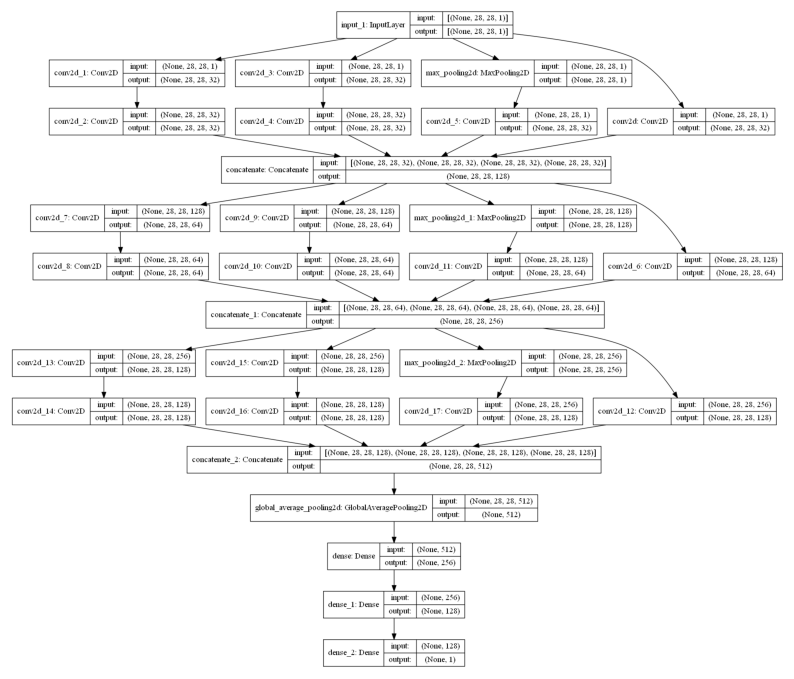

In [8]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pydot

# Visualizzazione della struttura del modello
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## CNN + Inception + Ottimizzazioni

Epoch 1/100
32/32 [==============================] - 4s 67ms/step - loss: 0.6029 - accuracy: 0.7250 - val_loss: 0.5776 - val_accuracy: 0.7449
Epoch 2/100
32/32 [==============================] - 2s 57ms/step - loss: 0.5841 - accuracy: 0.7290 - val_loss: 0.5691 - val_accuracy: 0.7449
Epoch 3/100
32/32 [==============================] - 2s 58ms/step - loss: 0.5951 - accuracy: 0.7290 - val_loss: 0.5574 - val_accuracy: 0.7449
Epoch 4/100
32/32 [==============================] - 2s 58ms/step - loss: 0.5774 - accuracy: 0.7290 - val_loss: 0.6049 - val_accuracy: 0.7449
Epoch 5/100
32/32 [==============================] - 2s 58ms/step - loss: 0.6129 - accuracy: 0.7290 - val_loss: 0.6076 - val_accuracy: 0.7449
Epoch 6/100
32/32 [==============================] - 2s 57ms/step - loss: 0.5969 - accuracy: 0.7290 - val_loss: 0.5611 - val_accuracy: 0.7449
Epoch 7/100
32/32 [==============================] - 2s 57ms/step - loss: 0.5754 - accuracy: 0.7290 - val_loss: 0.5660 - val_accuracy: 0.7449
Epoch 

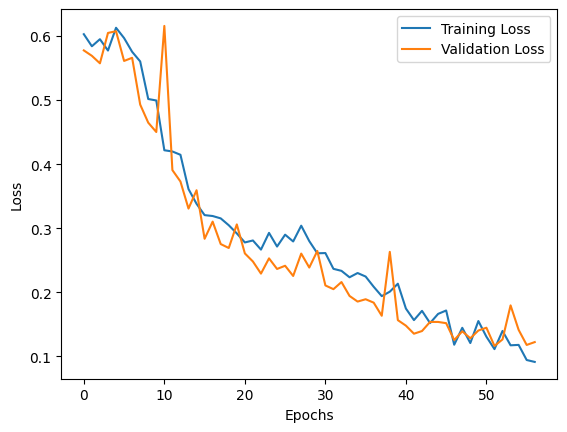

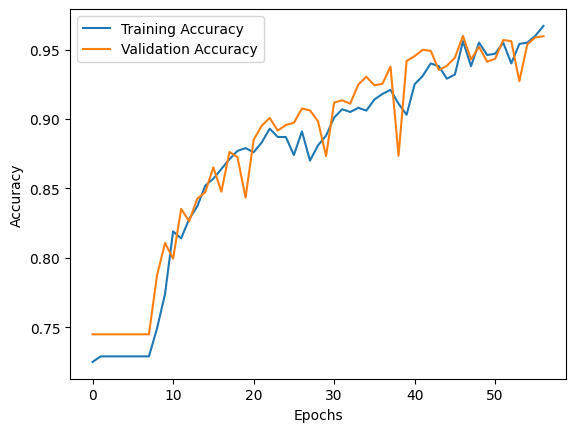

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

def inception_module(x, filters):
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

def create_inception_cnn_dropout(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = inception_module(inputs, 32)
    x = inception_module(x, 64)
    x = inception_module(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
model_opt = create_inception_cnn_dropout(input_shape)

model_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history2 = model_opt.fit(x_train_images, x_train_labels, epochs=100, verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])

# Plotting the training history
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
model_opt.evaluate(test_images, test_labels)

17/17 [==============================] - 0s 9ms/step - loss: 0.1195 - accuracy: 0.9637


[0.11954650282859802, 0.9637404680252075]

Con i dropout a 0.4 il best è 0.9637 (sul testing set obv)

## Ricerca miglior optimizer e loss function

In [17]:
# Come prima loss function si prova la Hinge Loss


# change labels from {0,1} to {-1,1}
# Copie degli array originali
adapted_train_labels = np.copy(x_train_labels)
adapted_valid_labels = np.copy(x_valid_labels)
adapted_test_labels = np.copy(test_labels)

# Sostituzione dei valori 0 con -1 nelle copie degli array
adapted_train_labels[y == 0] = -1
adapted_valid_labels[y == 0] = -1
adapted_test_labels[y == 0] = -1

print(adapted_test_labels)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 5232